# Importing the necessary Libraries


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# Importing Data and Exploring it

In [ ]:
root_path = '/content/data_ATB.csv'
btc_input_df = pd.read_csv(root_path)
btc_input_df.tail()

,Date,Open,High,Low,Close,Volume
3320,25/12/2023,2.73,2.74,2.67,2.67,1507
3321,26/12/2023,2.67,2.71,2.66,2.70,4893
3322,27/12/2023,2.70,2.71,2.68,2.70,4113
3323,28/12/2023,2.70,2.71,2.67,2.71,5030
3324,29/12/2023,2.71,2.71,2.68,2.70,822


In [ ]:
btc_input_df['Close']

0       8.07
1       8.20
2       8.24
3       8.19
4       8.20
        ... 
3320    2.67
3321    2.70
3322    2.70
3323    2.71
3324    2.70
Name: Close, Length: 3325, dtype: float64

In [ ]:
btc_input_df.shape

(3325, 6)

In [ ]:
btc_input_df.describe()

,Open,High,Low,Close,Volume
count,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000
mean,4.499883,4.529504,4.464848,4.502105,11242.652932
std,1.622954,1.630248,1.614076,1.620998,29913.038503
min,2.090000,2.120000,2.070000,2.090000,1.000000
25%,3.300000,3.370000,3.280000,3.330000,1377.000000
50%,4.270000,4.300000,4.250000,4.270000,4206.000000
75%,4.960000,4.990000,4.940000,4.970000,10636.000000
max,10.140000,10.150000,9.840000,10.130000,743796.000000


In [ ]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3325 entries, 0 to 3324
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3325 non-null   object 
 1   Open    3325 non-null   float64
 2   High    3325 non-null   float64
 3   Low     3325 non-null   float64
 4   Close   3325 non-null   float64
 5   Volume  3325 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 156.0+ KB


<Axes: title={'center': 'ATB Price'}, xlabel='Date'>

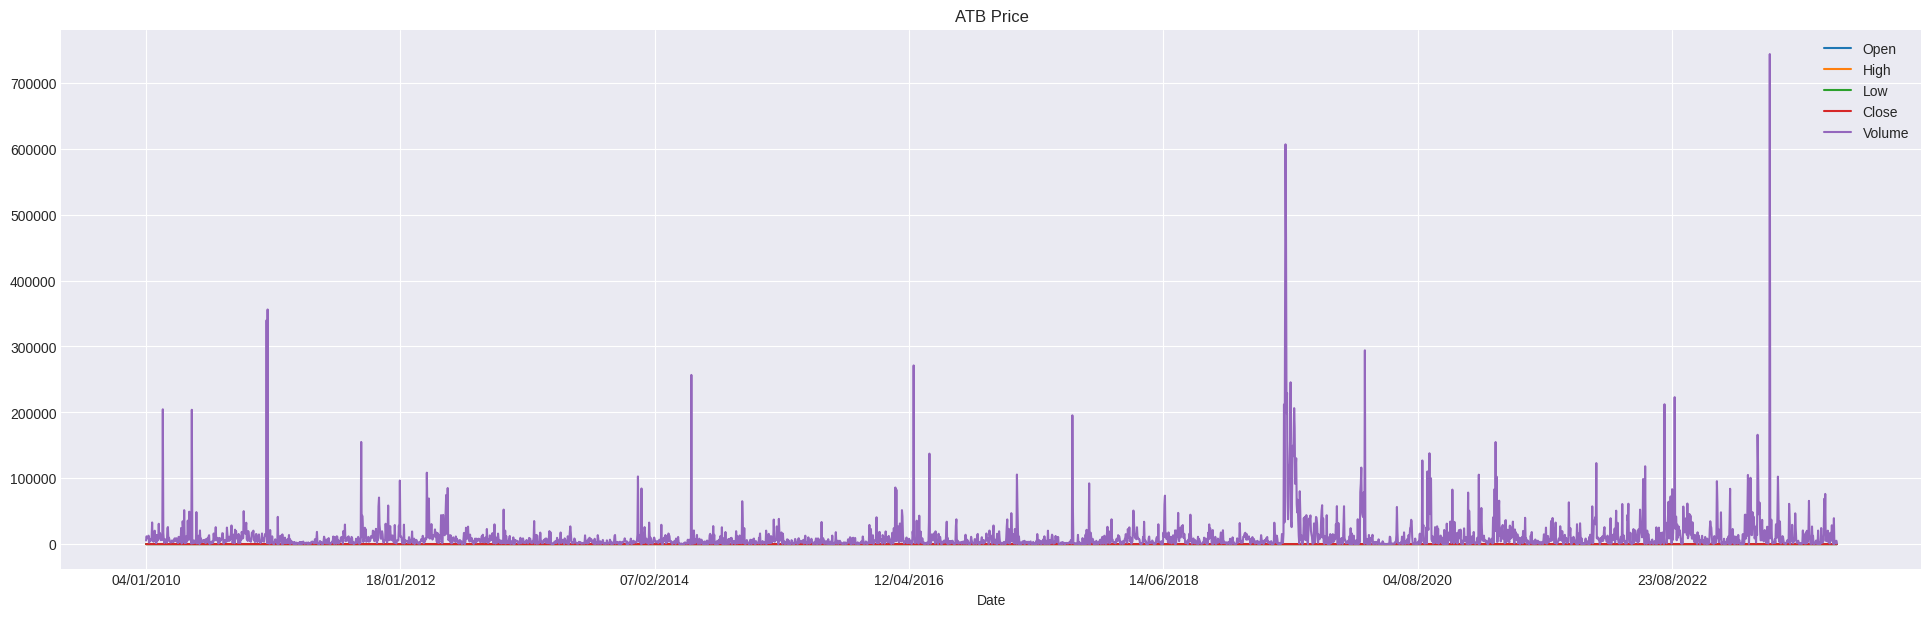

In [ ]:
btc_input_df.set_index("Date").plot(figsize=(24,7), title="ATB Price")

In [ ]:
display(btc_input_df.head())

group = btc_input_df.groupby('Date')

btc_closing_price_groupby_date = group['Close'].mean()

,Date,Open,High,Low,Close,Volume
0,04/01/2010,8.08,8.08,8.07,8.07,5439
1,05/01/2010,8.08,8.20,8.08,8.20,11742
2,06/01/2010,8.20,8.24,8.18,8.24,9859
3,07/01/2010,8.20,8.24,8.19,8.19,8924
4,08/01/2010,8.23,8.30,8.20,8.20,8736


In [ ]:
display(btc_closing_price_groupby_date.head(10))

print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

Date
01/02/2010    8.60
01/02/2011    6.49
01/02/2012    5.80
01/02/2013    5.00
01/02/2016    4.33
01/02/2017    4.62
01/02/2018    4.09
01/02/2019    3.64
01/02/2021    2.85
01/02/2022    2.60
Name: Close, dtype: float64

Length of btc_closing_price_groupby_date : 3325


# Calculating Different Indicators

<Axes: >

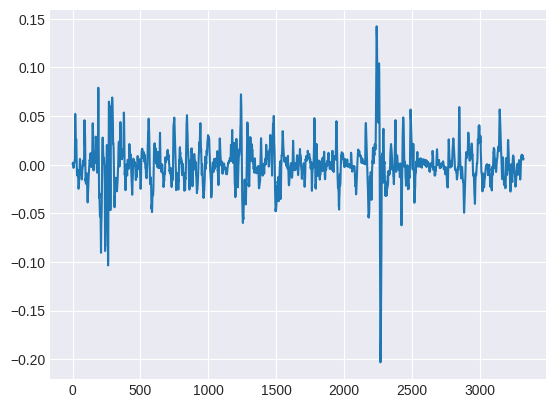

In [ ]:
btc_input_df['ema_12'] = btc_input_df['Close'].ewm(span=12).mean()
btc_input_df['ema_26'] = btc_input_df['Close'].ewm(span=26).mean()
btc_input_df['macd_fast'] = btc_input_df['ema_12'] - btc_input_df['ema_26']
btc_input_df['slow_macd'] = btc_input_df['macd_fast'].ewm(span=9).mean()
btc_input_df['macd'] = btc_input_df['macd_fast'] - btc_input_df['slow_macd']
btc_input_df['macd'].plot(kind='line')

<Axes: >

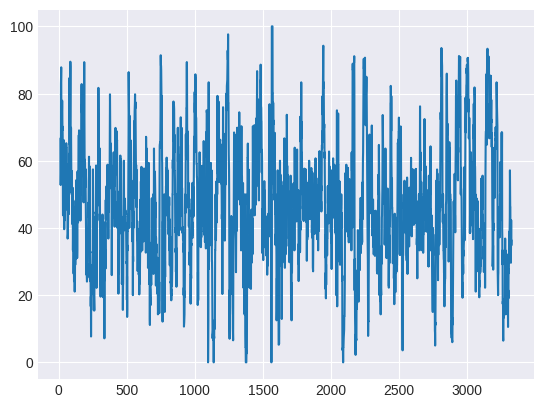

In [ ]:
change = btc_input_df['Close'].diff(1)
btc_input_df['Gain'] = change.mask(change<0,0)
btc_input_df['Loss'] = abs(change.mask(change>0,0))
btc_input_df['AVG_Gain'] = btc_input_df.Gain.rolling(14).mean()
btc_input_df['AVG_Loss'] = btc_input_df.Loss.rolling(14).mean()
btc_input_df['RS'] = btc_input_df['AVG_Gain']/btc_input_df['AVG_Loss']
btc_input_df['rsi'] = 100 - (100/(1+btc_input_df['RS']))
btc_input_df['rsi'].plot(kind='line')

# Train Test Split

In [ ]:
prediction_days = 100
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)

df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [ ]:
df_test.shape


(100, 1)

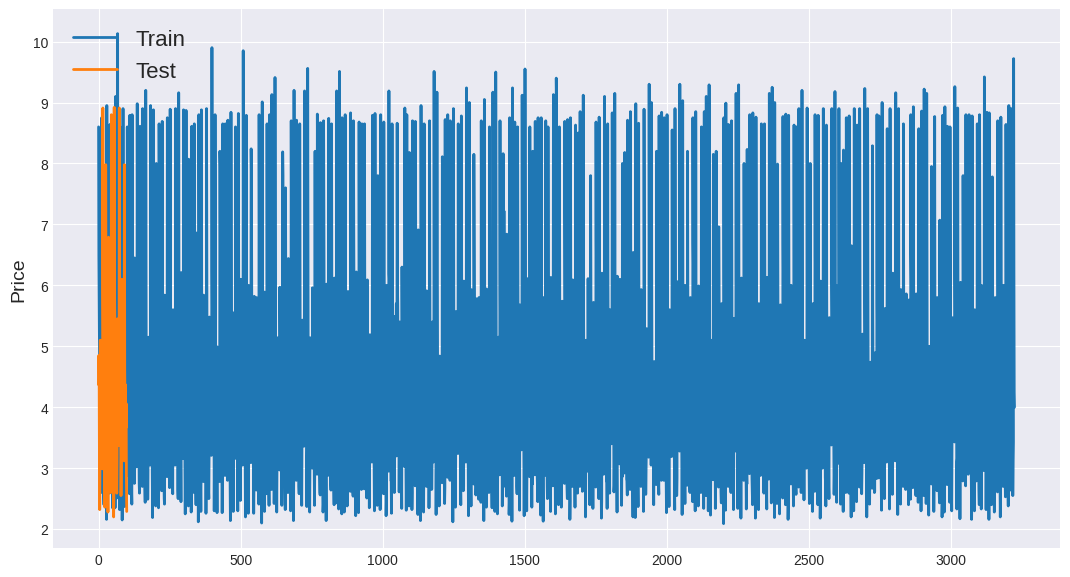

In [ ]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Min Max Scaling of Data post Train-Test Split </h3>
</div>



Scaling must be done after the data has been split into training and test sets — with each being scaled separately.

A common mistake when first using the LSTM is to first normalize the data before splitting the data.

The reason this is erroneous is that the normalization technique will use data from the test sets as a reference point when scaling the data as a whole. This will inadvertently influence the values of the training data, essentially resulting in data leakage from the test sets.


In [ ]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [ ]:
def dataset_generator_lstm(dataset, look_back=16):
    """
    Generates input-output pairs for an LSTM dataset.

    Args:
        dataset (numpy.ndarray): The dataset to generate input-output pairs from.
        look_back (int): The number of previous timesteps to use for prediction.

    Returns:
        numpy.ndarray: The input sequences.
        numpy.ndarray: The corresponding output values.
    """
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep.
    dataX, dataY = [], []

    # Iterate over the dataset, considering a "look_back" window of previous timesteps
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (3209, 16)
trainY:  (3209,)
testX:  (84, 16)
testY (84,)


In [ ]:
print("trainX: ", trainX)
# print("trainY: ", trainY)
# print("testY: ", testX)
# print("testY", testY)

trainX:  [[0.80970149 0.54726368 0.46144279 ... 0.32587065 0.3159204  0.29726368]
 [0.54726368 0.46144279 0.3619403  ... 0.3159204  0.29726368 0.25995025]
 [0.46144279 0.3619403  0.27860697 ... 0.29726368 0.25995025 0.22761194]
 ...
 [0.28731343 0.33084577 0.25497512 ... 0.12810945 0.16666667 0.94900498]
 [0.33084577 0.25497512 0.26243781 ... 0.16666667 0.94900498 0.51741294]
 [0.25497512 0.26243781 0.15920398 ... 0.94900498 0.51741294 0.26865672]]


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> For LSTM Reshape input ( trainX and testX ) to be 3-D of [samples, time steps, features] </h3>
</div>



### First check the current shape of trainX and testX

In [ ]:
print(trainX.shape)
print(testX.shape)

(3209, 16)
(84, 16)


### And now reshape trainX and testX

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (3209, 16, 1)
Shape of testX:  (84, 16, 1)


In [ ]:
print("trainX: ", trainX)
print(" ********** ")
print("testX: ", testX)

trainX:  [[[0.80970149]
  [0.54726368]
  [0.46144279]
  ...
  [0.32587065]
  [0.3159204 ]
  [0.29726368]]

 [[0.54726368]
  [0.46144279]
  [0.3619403 ]
  ...
  [0.3159204 ]
  [0.29726368]
  [0.25995025]]

 [[0.46144279]
  [0.3619403 ]
  [0.27860697]
  ...
  [0.29726368]
  [0.25995025]
  [0.22761194]]

 ...

 [[0.28731343]
  [0.33084577]
  [0.25497512]
  ...
  [0.12810945]
  [0.16666667]
  [0.94900498]]

 [[0.33084577]
  [0.25497512]
  [0.26243781]
  ...
  [0.16666667]
  [0.94900498]
  [0.51741294]]

 [[0.25497512]
  [0.26243781]
  [0.15920398]
  ...
  [0.94900498]
  [0.51741294]
  [0.26865672]]]
 ********** 
testX:  [[[0.32291667]
  [0.39434524]
  [0.3422619 ]
  ...
  [0.11755952]
  [0.11755952]
  [0.9985119 ]]

 [[0.39434524]
  [0.3422619 ]
  [0.13392857]
  ...
  [0.11755952]
  [0.9985119 ]
  [0.55803571]]

 [[0.3422619 ]
  [0.13392857]
  [0.01785714]
  ...
  [0.9985119 ]
  [0.55803571]
  [0.41666667]]

 ...

 [[0.18005952]
  [0.58035714]
  [0.43452381]
  ...
  [0.32291667]
  [0.29761

In [ ]:
# First checking the values for input_shape = (trainX.shape[1], trainX.shape[2])
# Note - `input_shape` of LSTM Model - `input_shape` is supposed to be (timesteps, n_features).

print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  16
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [ ]:
from keras.layers import Layer
import keras.backend as K
from keras.initializers import glorot_uniform
from keras.regularizers import l2

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer=glorot_uniform(),
                                 regularizer=l2(0.01),  # Example regularization
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=True))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(AttentionLayer())
# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 16, 64)            0         
                                                                 
 attention_layer (Attention  (None, 64)                80        
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#checkpoint_path = 'my_best_model.hdf5'

#checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             #monitor='val_loss',
                             #verbose=1,
                             #save_best_only=True,
                             #mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

callbacks = [earlystopping]
history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/300
101/101 [==============================] - 11s 74ms/step - loss: 0.0574 - val_loss: 0.0553
Epoch 2/300
101/101 [==============================] - 3s 31ms/step - loss: 0.0446 - val_loss: 0.0500
Epoch 3/300
101/101 [==============================] - 3s 31ms/step - loss: 0.0412 - val_loss: 0.0480
Epoch 4/300
101/101 [==============================] - 5s 48ms/step - loss: 0.0391 - val_loss: 0.0458
Epoch 5/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0367 - val_loss: 0.0390
Epoch 6/300
101/101 [==============================] - 3s 32ms/step - loss: 0.0333 - val_loss: 0.0331
Epoch 7/300
101/101 [==============================] - 4s 37ms/step - loss: 0.0314 - val_loss: 0.0323
Epoch 8/300
101/101 [==============================] - 5s 48ms/step - loss: 0.0305 - val_loss: 0.0299
Epoch 9/300
101/101 [==============================] - 3s 31ms/step - loss: 0.0298 - val_loss: 0.0270
Epoch 10/300
101/101 [==============================] - 3s 31ms/step - loss: 0.02

## Plot line graph to show Loss Numbers relative to the epoch

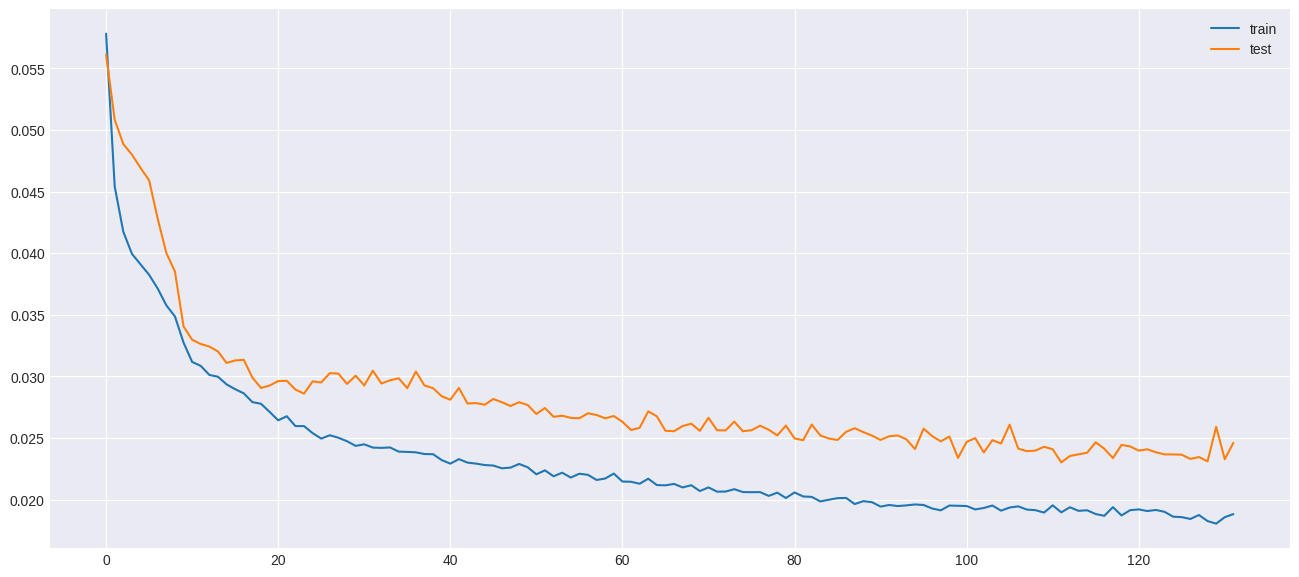

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LSTM Predictions using testX and plotting line graph against Actual testY </h3>
</div>




Due to scaling step done earlier with MinMaxScaler the predicted scale is between 0 and 1.
Now, I need to transfer this scale to the original data scale (real value). for example:[0.58439621 0.58439621 0.58439621 ... 0.81262134 0.81262134 0.81262134], the pred answer transfer to :[250 100 50 60 .....]
So here I am going to use `inverse_transform` to Scale back the data to the original representation.

In [ ]:
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)
predicted_btc_price_test_data = regressor.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

3/3 [==============================] - 1s 11ms/step


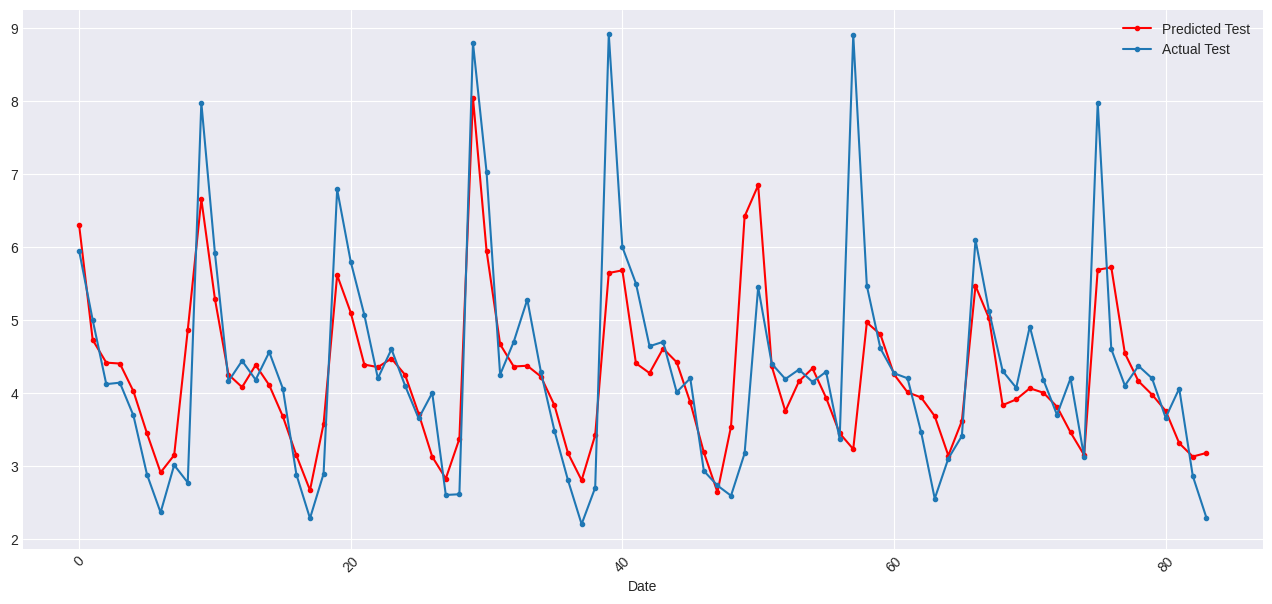

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.legend()
plt.show()

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LSTM Prediction using trainX and plotting line graph against Actual trainY </h3>
</div>

In [ ]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = regressor.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

101/101 [==============================] - 2s 21ms/step


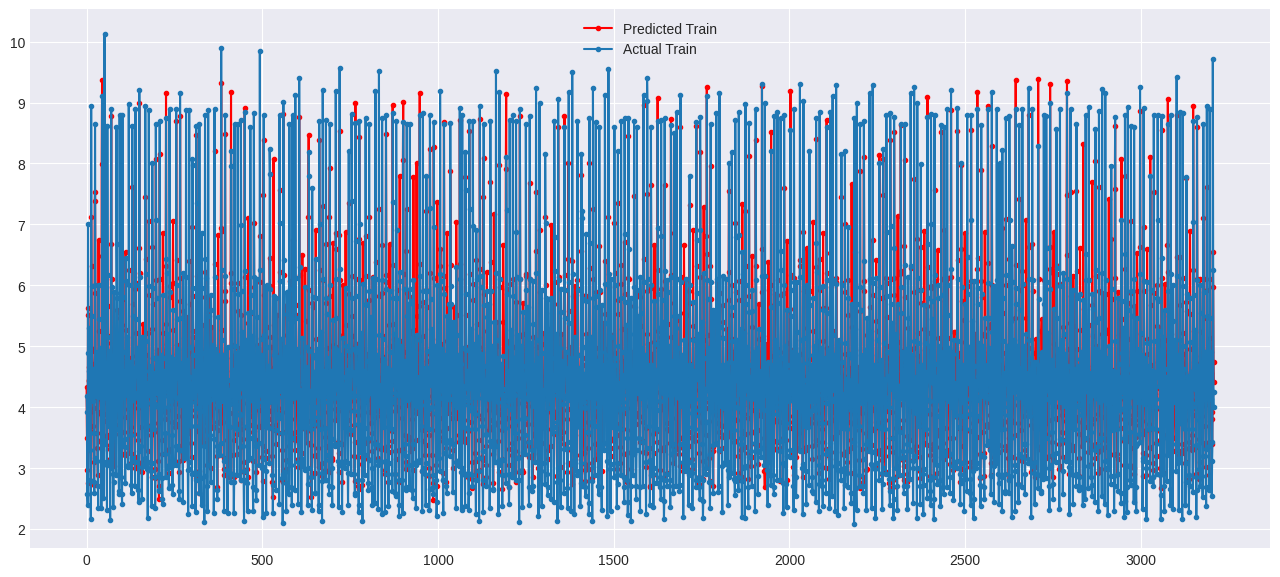

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

# RMSE - Test Data

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

# With 2 Layers + Dropout + lookback=5


Test RMSE: 1.019


# RMSE - Train Data

In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Train RMSE: %.3f' % rmse_lstm_train)

# With 2 Layers + Dropout + lookback=5

Train RMSE: 1.067


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Now Future Price Predictions - For 5 Days beyond the actual trading days for which I dont have the ground truth data (i.e. for 5-days into future for which I dont have actual Trading Price yet) </h3>
</div>

Note that the original Trading data (the .csv file used at the very top of this notebook) ended on 30-Oct-2021, but now I am going to forecast the Bitcoin Prices for 5 days beyond 30-Oct-2021, using the trained LSTM model above.

First check the shape of testX

Basically to predict tomorrow's value,

- feed into the model the past n(look_back) days’ values and we get tomorrow’s value as output.

- Similarly, to get the day after tomorrow’s value, feed-in past n-1 days’ values along with tomorrow’s value and the model output day after tomorrow’s value.

In [ ]:
testX
testX.shape

In [ ]:
lookback_period = 16

# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast for Future 5 days beyond 30-Oct-2021

testX_last_5_days = testX[testX.shape[0] - lookback_period :  ]

testX_last_5_days.shape

(16, 16, 1)

In [ ]:
testX_last_5_days

array([[[0.29613095],
        [0.31547619],
        [0.29017857],
        [0.3110119 ],
        [0.17410714],
        [0.9985119 ],
        [0.48660714],
        [0.35863095],
        [0.30803571],
        [0.29761905],
        [0.1875    ],
        [0.05208333],
        [0.13392857],
        [0.18005952],
        [0.58035714],
        [0.43452381]],

       [[0.31547619],
        [0.29017857],
        [0.3110119 ],
        [0.17410714],
        [0.9985119 ],
        [0.48660714],
        [0.35863095],
        [0.30803571],
        [0.29761905],
        [0.1875    ],
        [0.05208333],
        [0.13392857],
        [0.18005952],
        [0.58035714],
        [0.43452381],
        [0.3125    ]],

       [[0.29017857],
        [0.3110119 ],
        [0.17410714],
        [0.9985119 ],
        [0.48660714],
        [0.35863095],
        [0.30803571],
        [0.29761905],
        [0.1875    ],
        [0.05208333],
        [0.13392857],
        [0.18005952],
        [0.58035714],
      

In [ ]:

predicted_5_days_forecast_price_test_x = []

for i in range(2):
  predicted_forecast_price_test_x = regressor.predict(testX_last_5_days[i:i+1])

  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  # print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

print("Forecast for the next 2 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x))
# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast beyond 30-Oct-2021

1/1 [==============================] - 0s 24ms/step
Forecast for the next 2 Days Beyond the actual trading days  [[[3.8320274]]

 [[3.9106028]]]


In [ ]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

predicted_5_days_forecast_price_test_x.shape

(2, 1, 1)

In [ ]:
predicted_btc_price_test_data.shape

(84, 1)

In [ ]:
predicted_btc_price_test_data

array([[6.304599 ],
       [4.727314 ],
       [4.4147463],
       [4.402527 ],
       [4.0222707],
       [3.443794 ],
       [2.9084253],
       [3.1460538],
       [4.8607755],
       [6.656104 ],
       [5.288674 ],
       [4.250999 ],
       [4.078466 ],
       [4.3821726],
       [4.1057506],
       [3.6782331],
       [3.142629 ],
       [2.665463 ],
       [3.5743732],
       [5.6148686],
       [5.101723 ],
       [4.3882437],
       [4.35332  ],
       [4.4707775],
       [4.247987 ],
       [3.714984 ],
       [3.1250763],
       [2.8247855],
       [3.370484 ],
       [8.048385 ],
       [5.949443 ],
       [4.6663876],
       [4.3616576],
       [4.3724833],
       [4.2242174],
       [3.8297467],
       [3.1719637],
       [2.8016832],
       [3.4210649],
       [5.644211 ],
       [5.6806993],
       [4.4062095],
       [4.2716193],
       [4.6085963],
       [4.420585 ],
       [3.8704944],
       [3.183841 ],
       [2.6395838],
       [3.537828 ],
       [6.420013 ],


In [ ]:
predicted_5_days_forecast_price_test_x

array([3.8320274, 3.9106028], dtype=float32)

In [ ]:

predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()

predicted_5_days_forecast_price_test_x


array([3.8320274, 3.9106028], dtype=float32)

In [ ]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()

predicted_btc_price_test_data

array([6.304599 , 4.727314 , 4.4147463, 4.402527 , 4.0222707, 3.443794 ,
       2.9084253, 3.1460538, 4.8607755, 6.656104 , 5.288674 , 4.250999 ,
       4.078466 , 4.3821726, 4.1057506, 3.6782331, 3.142629 , 2.665463 ,
       3.5743732, 5.6148686, 5.101723 , 4.3882437, 4.35332  , 4.4707775,
       4.247987 , 3.714984 , 3.1250763, 2.8247855, 3.370484 , 8.048385 ,
       5.949443 , 4.6663876, 4.3616576, 4.3724833, 4.2242174, 3.8297467,
       3.1719637, 2.8016832, 3.4210649, 5.644211 , 5.6806993, 4.4062095,
       4.2716193, 4.6085963, 4.420585 , 3.8704944, 3.183841 , 2.6395838,
       3.537828 , 6.420013 , 6.8474183, 4.3641224, 3.7493784, 4.157795 ,
       4.33709  , 3.9329607, 3.446034 , 3.2292435, 4.965412 , 4.802148 ,
       4.2544203, 4.008152 , 3.936828 , 3.6809444, 3.1407452, 3.6162755,
       5.4688334, 5.021332 , 3.8320274, 3.910603 , 4.063222 , 4.0022435,
       3.811246 , 3.4581141, 3.147617 , 5.6883883, 5.7212977, 4.542578 ,
       4.160204 , 3.9765823, 3.7544405, 3.3101904, 

In [ ]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_5_days_forecast_price_test_x))

predicted_btc_test_concatenated

predicted_btc_test_concatenated.shape


(86,)

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Finally Plot entire Predictions of Test Data (including the Future 5-days ) against Actual testY </h3>
</div>

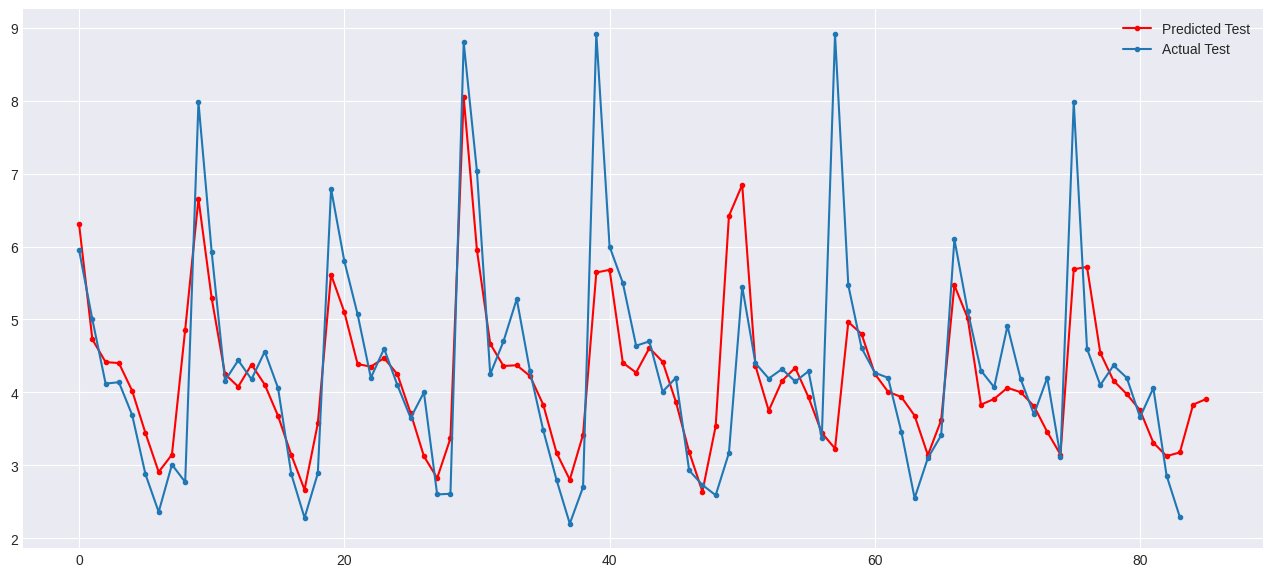

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()

plt.show()